In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
from sklearn import ensemble, preprocessing
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import warnings

warnings.simplefilter(action='ignore')

train = pd.read_csv('datasets/train_cleaned_modeling.csv')
test = pd.read_csv('datasets/test_cleaned.csv')
weather = pd.read_csv('datasets/weather_cleaned.csv')
#spray = pd.read_csv('datasets/spray.csv')
ccm = pd.read_csv('datasets/ccmtrain.csv')
#train.columns = train.columns.str.lower()
test.columns=test.columns.str.lower()
weather.columns=weather.columns.str.lower()

In [2]:
train.shape

(10506, 153)

In [3]:
weather.shape

(2944, 40)

# For generating the Cross Correlation map dataset

In [4]:
# create function to add date ranges
def ccmgenerator(data, maxweeks=8):
    # Generate average temperature
    # Initialize counter
    n=1
    while n!=(maxweeks+1):
        for i in range(n, maxweeks+1):
            # Generate empty columns
            targettemp='avgtemp_week'+str(n)+'_'+str(i)
            targetlight='avglight_week'+str(n)+'_'+str(i)
            targethumid='avghumid_week'+str(n)+'_'+str(i)
            targetrain='avgrain_week'+str(n)+'_'+str(i)
            targetwind='avgwind_week'+str(n)+'_'+str(i)
            
            data[targettemp]=np.NaN
            data[targetlight]=np.NaN
            data[targethumid]=np.NaN
            data[targetrain]=np.NaN
            data[targetwind]=np.NaN
            
            # Filling in average temperature         
            for j in data.index.to_list():
            #for j in data.index:
                startdate = datetime.fromisoformat(data['date'][j])
                startpoint = startdate+timedelta(weeks=-(n))
                endpoint = startdate+timedelta(weeks=-(i))
                # Filling in average temperature  
                try:
                    data.loc[j,targettemp]=avgtemp(startpoint,endpoint)
                except:
                    pass
                # Fillng in average light
                try:
                    data.loc[j,targetlight]=avglight(startpoint,endpoint)
                except:
                    pass
                # Filling in average humid
                try:
                    data.loc[j,targethumid]=avghumid(startpoint,endpoint)
                except:
                    pass
                # Filling in average rain
                try:
                    data.loc[j,targetrain]=avgrain(startpoint,endpoint) 
                except:
                    pass
                # Filling in average wind
                try:
                    data.loc[j,targetwind]=avgwind(startpoint,endpoint)
                except:
                    pass
            
        n+=1
    return data

In [5]:
def avgtemp(startdate,enddate):
    datelist=[]
    delta = startdate-enddate
    for i in range(delta.days + 1):
        day = enddate + timedelta(days=i)
        datelist.append(day.date().isoformat())
    # Converting to celcius
    return (np.mean(weather.loc[(weather.date.isin(datelist)) & (weather['station']==2)]['tavg'])-32)*5/9              


In [6]:
def avghumid(startdate,enddate):
    datelist=[]
    delta = startdate-enddate
    for i in range(delta.days + 1):
        day = enddate + timedelta(days=i)
        datelist.append(day.date().isoformat())
    humidlist=[]

    # Relative Humidity formula where td = dewpoint temp and ta = average temp
    td=(weather.loc[(weather.date.isin(datelist)) & (weather['station']==2)]['dewpoint']-32)*5/9
    ta=(weather.loc[(weather.date.isin(datelist)) & (weather['station']==2)]['tavg']-32)*5/9
    return np.mean(100*(np.exp((17.625*td)/(243.04+td))/np.exp((17.625*ta)/(243.04+ta))))
    

In [7]:
def avglight(startdate,enddate):
    datelist=[]
    delta = startdate-enddate
    for i in range(delta.days + 1):
        day = enddate + timedelta(days=i)
        datelist.append(day.date().isoformat())
    # 
    return (np.mean(weather.loc[(weather.date.isin(datelist)) & (weather['station']==2)]['dayhrs']))      

In [8]:
def avgrain(startdate,enddate):
    datelist=[]
    delta = startdate-enddate
    for i in range(delta.days + 1):
        day = enddate + timedelta(days=i)
        datelist.append(day.date().isoformat())
    return (np.mean(weather.loc[(weather.date.isin(datelist)) & (weather['station']==2)]['preciptotal']))    

In [9]:
def avgwind(startdate,enddate):
    datelist=[]
    delta = startdate-enddate
    for i in range(delta.days + 1):
        day = enddate + timedelta(days=i)
        datelist.append(day.date().isoformat())
    # Converting to celcius
    return (np.mean(weather.loc[(weather.date.isin(datelist)) & (weather['station']==2)]['avgspeed']))  

In [10]:
uniquedates=train[~train.duplicated(['date'],keep='last')]

In [11]:
uniquedataset=ccmgenerator(uniquedates, maxweeks=8)
uniquedataset

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,multiplebins,year,month,...,avgtemp_week7_8,avglight_week7_8,avghumid_week7_8,avgrain_week7_8,avgwind_week7_8,avgtemp_week8_8,avglight_week8_8,avghumid_week8_8,avgrain_week8_8,avgwind_week8_8
24,2007-05-29,CULEX RESTUANS,T159,41.732984,-87.649642,1,0,0,2007,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,2007-06-05,CULEX RESTUANS,T220,41.963976,-87.691810,1,0,0,2007,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,2007-06-26,CULEX RESTUANS,T219,41.966987,-87.674677,1,0,0,2007,6,...,19.618056,14.152083,45.436575,0.00000,10.9875,20.000000,14.016667,54.526426,0.0,9.6
200,2007-06-29,CULEX PIPIENS/RESTUANS,T160,41.903002,-87.688267,1,0,0,2007,6,...,21.284722,14.270833,45.557101,0.00250,9.2875,39.722222,14.133333,12.467222,0.0,10.4
274,2007-07-02,CULEX PIPIENS/RESTUANS,T095,41.704336,-87.703736,1,0,0,2007,7,...,18.611111,14.381250,49.959921,0.00250,9.1375,19.444444,14.250000,35.770152,0.0,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10019,2013-08-29,CULEX PIPIENS/RESTUANS,T054C,41.925652,-87.633590,1,0,0,2013,8,...,24.722222,15.093750,64.274585,0.10625,7.8750,22.222222,15.133333,63.636950,0.0,7.7
10162,2013-09-06,CULEX PIPIENS/RESTUANS,T054C,41.925652,-87.633590,3,0,0,2013,9,...,27.708333,14.931250,59.024993,0.00375,8.1125,21.666667,15.016667,54.950842,0.0,5.4
10301,2013-09-12,CULEX PIPIENS,T054C,41.925652,-87.633590,2,0,0,2013,9,...,25.763889,14.775000,55.266831,0.00125,8.9500,31.111111,14.866667,57.265097,0.0,9.4
10413,2013-09-19,CULEX PIPIENS,T054C,41.925652,-87.633590,2,0,0,2013,9,...,19.930556,14.562500,61.560600,0.02375,7.5250,21.111111,14.666667,52.831566,0.0,3.9


In [12]:
uniquedatestest=test[~test.duplicated(['date'],keep='last')]

In [13]:
uniquedatasettest=ccmgenerator(uniquedatestest, maxweeks=8)
uniquedatasettest

,id,date,species,trap,latitude,longitude,timestamp,year,month,week,...,avgtemp_week7_8,avglight_week7_8,avghumid_week7_8,avgrain_week7_8,avgwind_week7_8,avgtemp_week8_8,avglight_week8_8,avghumid_week8_8,avgrain_week8_8,avgwind_week8_8
1207,1208,2008-06-11,CULEX ERRATICUS,T054C,41.925652,-87.63359,2008-06-11,2008,6,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2415,2416,2008-06-17,CULEX ERRATICUS,T054C,41.925652,-87.63359,2008-06-17,2008,6,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3632,3633,2008-06-24,CULEX ERRATICUS,T054C,41.925652,-87.63359,2008-06-24,2008,6,26,...,15.370370,14.111111,57.549610,0.12500,9.4500,NaN,NaN,NaN,NaN,NaN
4843,4844,2008-07-01,CULEX ERRATICUS,T054C,41.925652,-87.63359,2008-07-01,2008,7,27,...,12.916667,14.345833,61.339902,0.31125,11.0375,19.444444,14.216667,41.755806,0.0,8.8
6052,6053,2008-07-04,CULEX ERRATICUS,T054C,41.925652,-87.63359,2008-07-04,2008,7,27,...,11.527778,14.450000,65.083037,0.22500,9.9000,10.000000,14.333333,56.186790,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111424,111425,2014-09-05,CULEX ERRATICUS,T054C,41.925652,-87.63359,2014-09-05,2014,9,36,...,21.875000,14.956250,60.941854,0.47125,7.9125,22.777778,15.033333,51.356790,0.0,6.5
112646,112647,2014-09-11,CULEX ERRATICUS,T054C,41.925652,-87.63359,2014-09-11,2014,9,37,...,22.847222,14.804167,59.175634,0.02375,8.2250,20.000000,14.900000,58.695968,0.0,5.1
113866,113867,2014-09-18,CULEX ERRATICUS,T054C,41.925652,-87.63359,2014-09-18,2014,9,38,...,22.291667,14.595833,60.203674,0.00500,9.2250,20.000000,14.700000,56.577353,0.0,8.2
115084,115085,2014-09-25,CULEX ERRATICUS,T054C,41.925652,-87.63359,2014-09-25,2014,9,39,...,23.888889,14.350000,61.214215,0.26250,7.0750,23.333333,14.483333,59.491585,0.0,8.5


In [14]:
 ccmmask=['date','avgtemp_week1_1', 'avglight_week1_1', 'avghumid_week1_1', 'avgrain_week1_1',
 'avgwind_week1_1', 'avgtemp_week1_2', 'avglight_week1_2', 'avghumid_week1_2',
 'avgrain_week1_2', 'avgwind_week1_2', 'avgtemp_week1_3', 'avglight_week1_3',
 'avghumid_week1_3', 'avgrain_week1_3', 'avgwind_week1_3', 'avgtemp_week1_4',
 'avglight_week1_4', 'avghumid_week1_4', 'avgrain_week1_4', 'avgwind_week1_4',
 'avgtemp_week1_5', 'avglight_week1_5', 'avghumid_week1_5', 'avgrain_week1_5',
 'avgwind_week1_5', 'avgtemp_week1_6', 'avglight_week1_6', 'avghumid_week1_6',
 'avgrain_week1_6', 'avgwind_week1_6', 'avgtemp_week1_7', 'avglight_week1_7',
 'avghumid_week1_7', 'avgrain_week1_7', 'avgwind_week1_7', 'avgtemp_week1_8',
 'avglight_week1_8', 'avghumid_week1_8', 'avgrain_week1_8', 'avgwind_week1_8',
 'avgtemp_week2_2', 'avglight_week2_2', 'avghumid_week2_2', 'avgrain_week2_2',
 'avgwind_week2_2', 'avgtemp_week2_3', 'avglight_week2_3', 'avghumid_week2_3',
 'avgrain_week2_3', 'avgwind_week2_3', 'avgtemp_week2_4', 'avglight_week2_4',
 'avghumid_week2_4', 'avgrain_week2_4', 'avgwind_week2_4', 'avgtemp_week2_5',
 'avglight_week2_5', 'avghumid_week2_5', 'avgrain_week2_5', 'avgwind_week2_5',
 'avgtemp_week2_6', 'avglight_week2_6', 'avghumid_week2_6', 'avgrain_week2_6',
 'avgwind_week2_6', 'avgtemp_week2_7', 'avglight_week2_7', 'avghumid_week2_7',
 'avgrain_week2_7', 'avgwind_week2_7', 'avgtemp_week2_8', 'avglight_week2_8',
 'avghumid_week2_8', 'avgrain_week2_8', 'avgwind_week2_8', 'avgtemp_week3_3',
 'avglight_week3_3', 'avghumid_week3_3', 'avgrain_week3_3', 'avgwind_week3_3',
 'avgtemp_week3_4', 'avglight_week3_4', 'avghumid_week3_4', 'avgrain_week3_4',
 'avgwind_week3_4', 'avgtemp_week3_5', 'avglight_week3_5', 'avghumid_week3_5',
 'avgrain_week3_5', 'avgwind_week3_5', 'avgtemp_week3_6', 'avglight_week3_6',
 'avghumid_week3_6', 'avgrain_week3_6', 'avgwind_week3_6', 'avgtemp_week3_7',
 'avglight_week3_7', 'avghumid_week3_7', 'avgrain_week3_7', 'avgwind_week3_7',
 'avgtemp_week3_8', 'avglight_week3_8', 'avghumid_week3_8', 'avgrain_week3_8',
 'avgwind_week3_8', 'avgtemp_week4_4', 'avglight_week4_4', 'avghumid_week4_4',
 'avgrain_week4_4', 'avgwind_week4_4', 'avgtemp_week4_5', 'avglight_week4_5',
 'avghumid_week4_5', 'avgrain_week4_5', 'avgwind_week4_5', 'avgtemp_week4_6',
 'avglight_week4_6', 'avghumid_week4_6', 'avgrain_week4_6', 'avgwind_week4_6',
 'avgtemp_week4_7', 'avglight_week4_7', 'avghumid_week4_7', 'avgrain_week4_7',
 'avgwind_week4_7', 'avgtemp_week4_8', 'avglight_week4_8', 'avghumid_week4_8',
 'avgrain_week4_8', 'avgwind_week4_8', 'avgtemp_week5_5', 'avglight_week5_5',
 'avghumid_week5_5', 'avgrain_week5_5', 'avgwind_week5_5', 'avgtemp_week5_6',
 'avglight_week5_6', 'avghumid_week5_6', 'avgrain_week5_6', 'avgwind_week5_6',
 'avgtemp_week5_7', 'avglight_week5_7', 'avghumid_week5_7', 'avgrain_week5_7',
 'avgwind_week5_7', 'avgtemp_week5_8', 'avglight_week5_8', 'avghumid_week5_8',
 'avgrain_week5_8', 'avgwind_week5_8', 'avgtemp_week6_6', 'avglight_week6_6',
 'avghumid_week6_6', 'avgrain_week6_6', 'avgwind_week6_6', 'avgtemp_week6_7',
 'avglight_week6_7', 'avghumid_week6_7', 'avgrain_week6_7', 'avgwind_week6_7',
 'avgtemp_week6_8', 'avglight_week6_8', 'avghumid_week6_8', 'avgrain_week6_8',
 'avgwind_week6_8', 'avgtemp_week7_7', 'avglight_week7_7', 'avghumid_week7_7',
 'avgrain_week7_7', 'avgwind_week7_7', 'avgtemp_week7_8', 'avglight_week7_8',
 'avghumid_week7_8', 'avgrain_week7_8', 'avgwind_week7_8', 'avgtemp_week8_8',
 'avglight_week8_8', 'avghumid_week8_8', 'avgrain_week8_8', 'avgwind_week8_8']

In [15]:
uniquedataset

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,multiplebins,year,month,...,avgtemp_week7_8,avglight_week7_8,avghumid_week7_8,avgrain_week7_8,avgwind_week7_8,avgtemp_week8_8,avglight_week8_8,avghumid_week8_8,avgrain_week8_8,avgwind_week8_8
24,2007-05-29,CULEX RESTUANS,T159,41.732984,-87.649642,1,0,0,2007,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,2007-06-05,CULEX RESTUANS,T220,41.963976,-87.691810,1,0,0,2007,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,2007-06-26,CULEX RESTUANS,T219,41.966987,-87.674677,1,0,0,2007,6,...,19.618056,14.152083,45.436575,0.00000,10.9875,20.000000,14.016667,54.526426,0.0,9.6
200,2007-06-29,CULEX PIPIENS/RESTUANS,T160,41.903002,-87.688267,1,0,0,2007,6,...,21.284722,14.270833,45.557101,0.00250,9.2875,39.722222,14.133333,12.467222,0.0,10.4
274,2007-07-02,CULEX PIPIENS/RESTUANS,T095,41.704336,-87.703736,1,0,0,2007,7,...,18.611111,14.381250,49.959921,0.00250,9.1375,19.444444,14.250000,35.770152,0.0,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10019,2013-08-29,CULEX PIPIENS/RESTUANS,T054C,41.925652,-87.633590,1,0,0,2013,8,...,24.722222,15.093750,64.274585,0.10625,7.8750,22.222222,15.133333,63.636950,0.0,7.7
10162,2013-09-06,CULEX PIPIENS/RESTUANS,T054C,41.925652,-87.633590,3,0,0,2013,9,...,27.708333,14.931250,59.024993,0.00375,8.1125,21.666667,15.016667,54.950842,0.0,5.4
10301,2013-09-12,CULEX PIPIENS,T054C,41.925652,-87.633590,2,0,0,2013,9,...,25.763889,14.775000,55.266831,0.00125,8.9500,31.111111,14.866667,57.265097,0.0,9.4
10413,2013-09-19,CULEX PIPIENS,T054C,41.925652,-87.633590,2,0,0,2013,9,...,19.930556,14.562500,61.560600,0.02375,7.5250,21.111111,14.666667,52.831566,0.0,3.9


In [16]:
newtrain=train.merge(uniquedataset[ccmmask],on='date',validate='m:m',suffixes=None)

In [40]:
newtrain=newtrain.fillna(newtrain.mean())

In [18]:
newtest=test.merge(uniquedatasettest[ccmmask],on='date',validate='m:m',suffixes=None)

In [41]:
newtest=newtest.fillna(newtest.mean())

In [42]:
newtrain.isnull()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,multiplebins,year,month,...,avgtemp_week7_8,avglight_week7_8,avghumid_week7_8,avgrain_week7_8,avgwind_week7_8,avgtemp_week8_8,avglight_week8_8,avghumid_week8_8,avgrain_week8_8,avgwind_week8_8
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10502,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10503,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10504,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [58]:
newtest=pd.read_csv('datasets/test_cleaned_ccm.csv')

In [60]:
test

,id,date,species,trap,latitude,longitude,timestamp,year,month,week,...,t230,t231,t232,t233,t235,t236,t237,t238,t900,t903
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,0,0,0,0,0,0,0,0,0,0
1,2,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,0,0,0,0,0,0,0,0,0,0
2,3,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,0,0,0,0,0,0,0,0,0,0
3,4,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,0,0,0,0,0,0,0,0,0,0
4,5,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,0,0,0,0,0,0,0,0,0,0
116289,116290,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,0,0,0,0,0,0,0,0,0,0
116290,116291,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,0,0,0,0,0,0,0,0,0,0
116291,116292,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,0,0,0,0,0,0,0,0,0,0


In [59]:
newtest


,id,date,species,trap,latitude,longitude,timestamp,year,month,week,...,avgtemp_week7_8,avglight_week7_8,avghumid_week7_8,avgrain_week7_8,avgwind_week7_8,avgtemp_week8_8,avglight_week8_8,avghumid_week8_8,avgrain_week8_8,avgwind_week8_8
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
1,2,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
2,3,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
3,4,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
4,5,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000
116289,116290,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000
116290,116291,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000
116291,116292,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000


In [44]:
# Do not run unless there is a need to regenerate the dataset
newtrain.to_csv('datasets/train_cleaned_modelling_ccm.csv',index=False)


In [45]:
# Do not run unless there is a need to regenerate the dataset
newtest.to_csv('datasets/test_cleaned_ccm.csv',index=False)

In [43]:
newtest

,id,date,species,trap,latitude,longitude,timestamp,year,month,week,...,avgtemp_week7_8,avglight_week7_8,avghumid_week7_8,avgrain_week7_8,avgwind_week7_8,avgtemp_week8_8,avglight_week8_8,avghumid_week8_8,avgrain_week8_8,avgwind_week8_8
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
1,2,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
2,3,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
3,4,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
4,5,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991,2008-06-11,2008,6,24,...,21.915134,14.828484,59.577017,0.176391,8.986214,21.790620,14.859188,57.347477,0.146243,8.429362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000
116289,116290,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000
116290,116291,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000
116291,116292,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590,2014-10-02,2014,10,40,...,22.708333,14.085417,63.529818,0.165000,9.437500,23.888889,14.216667,61.777544,0.000000,9.300000


# Generating the correlation maps

In [23]:
#ccm = pd.read_csv('datasets/ccmtrain.csv')

In [24]:
def maskgen(colname,maxweeks=8):
    mask=[]
    n=1
    while n!=(maxweeks+1):
        for i in range(n,maxweeks+1):
            mask.append(colname+str(n)+'_'+str(i))
        n+=1
    return mask

In [25]:
avgtemp=maskgen('avgtemp_week')
avglight=maskgen('avglight_week')
avghumid=maskgen('avghumid_week')
avgrain=maskgen('avgrain_week')
avgwind=maskgen('avgwind_week')

In [26]:
def visualiser(column,target='nummosquitos',data=newtrain):
    series=data[column].corrwith(data[target],method='spearman')
    numlist=['1','2','3','4','5','6','7','8']
    tri=pd.DataFrame(index=numlist[::-1],columns=numlist)
    for i in range(0,len(series)):
        row=(series.index[i][-3])
        col=(series.index[i][-1])
        tri.loc[row,col]=float(series[i])
    tri=tri.fillna(0)
    mask=tri==0
    sns.heatmap(tri,mask=mask,cmap='coolwarm')

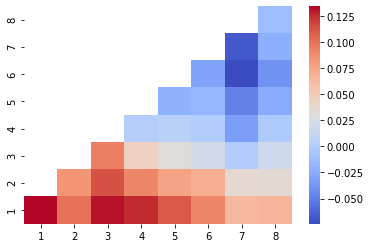

In [46]:
visualiser(avgtemp)

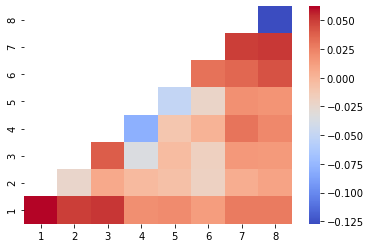

In [47]:
visualiser(avghumid)

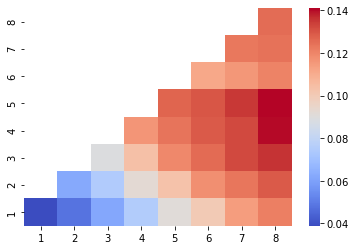

In [48]:
visualiser(avglight)

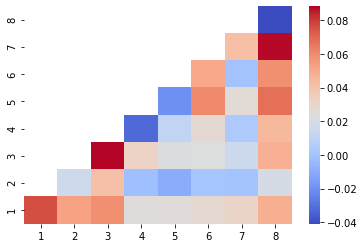

In [49]:
visualiser(avgrain)

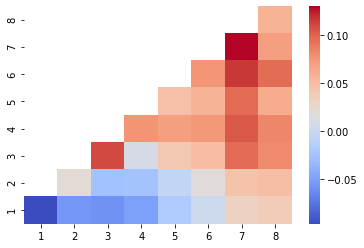

In [50]:
visualiser(avgwind)

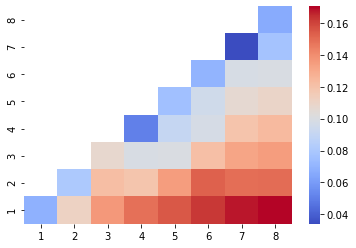

In [51]:
visualiser(avgtemp,target='wnvpresent')

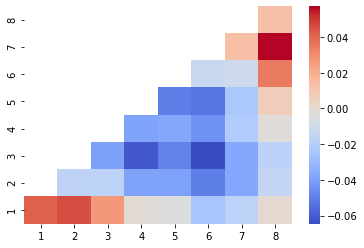

In [52]:
visualiser(avghumid,target='wnvpresent')

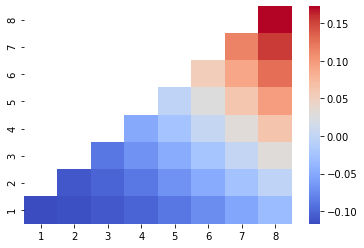

In [53]:
visualiser(avglight,target='wnvpresent')

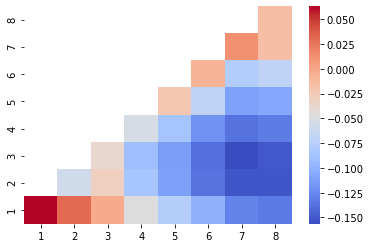

In [54]:
visualiser(avgrain,target='wnvpresent')

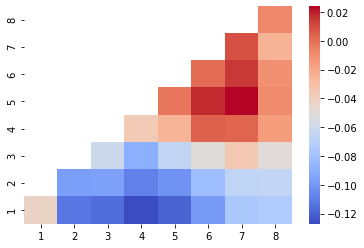

In [55]:
visualiser(avgwind,target='wnvpresent')